In [1]:
# Import Stuff

import os
import torch
import random
import IPython
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa.display
import matplotlib.pyplot as plt

from sklearn import svm
from IPython.display import display
import torchvision.transforms as transforms
from scipy.stats import describe, skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

#from google.colab import drive # Add this if you are using google colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## config

In [3]:
class CFG:
    # Some direction used
    BASE_DIR = os.path.join(os.getcwd(), "drive/MyDrive/HMS" )
    SAVE_DIR = os.path.join(os.getcwd(), "hms-harmful-brain-activity-classification/numpy")

    # Init dic that need to convert class to num
    class_lst       = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    class_label_dic = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}
    label_class_dic = {0: 'Seizure', 1: 'LPD', 2: 'GPD', 3: 'LRDA', 4: 'GRDA', 5: 'Other'}

    # sample rate & frequency
    # The reason I use num_sample here, is you could use different chunk to train
    # Here i give you is the default = sample_freq_eeg * data_duration_eeg
    # but from my perspective data_duration_eeg better < 50
    sample_freq_eeg   = 200
    data_duration_eeg = 50
    num_sample_eeg    = sample_freq_eeg * data_duration_eeg

    sample_freq_spec  = 1/2
    data_duration_spec = 600
    num_sample_spec    = int(sample_freq_spec * data_duration_spec)

    # You could also choose to use different features for egg, there are 20 features in total
    # The one i give you is 8
    eeg_features = ["Fp1", "T3", "C3", "O1", "Fp2", "C4", "T4", "O2"]

    # data type
    egg_dtype  = "float32"
    spec_dtype = "float32"

    # seed
    seed = 42

    # batch size
    BATCH_SIZE = 64

    # device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

# first50%

In [ ]:
# import datas from csv file into pandas.core.fram.DataFrame data type
# you probably only need to chance the base_dir if you using different dir
print("Importing data from csv file ......")
df      = pd.read_csv(os.path.join(CFG.BASE_DIR, "train.csv"))
df_test = pd.read_csv(os.path.join(CFG.BASE_DIR, "test.csv"))
id = np.unique(df['spectrogram_id'])
id = id[0:int(len(id)/2)]
df = df[df['spectrogram_id'].isin(id)]
print("Finish Importing.\n")

# If you would like to save files, i already created two folders
os.makedirs(os.path.join(CFG.BASE_DIR, 'train_spectrograms'), exist_ok=True)
os.makedirs(os.path.join(CFG.BASE_DIR, 'test_spectrograms'),  exist_ok=True)

Importing data from csv file ......
Finish Importing.



last50%

In [4]:
print("Importing data from csv file ......")
df      = pd.read_csv(os.path.join(CFG.BASE_DIR, "train.csv"))
df_test = pd.read_csv(os.path.join(CFG.BASE_DIR, "test.csv"))
id = np.unique(df['spectrogram_id'])
id = id[int(len(id)/2):]
df = df[df['spectrogram_id'].isin(id)]
print("Finish Importing.\n")

# If you would like to save files, i already created two folders
os.makedirs(os.path.join(CFG.BASE_DIR, 'train_spectrograms'), exist_ok=True)
os.makedirs(os.path.join(CFG.BASE_DIR, 'test_spectrograms'),  exist_ok=True)

Importing data from csv file ......
Finish Importing.



## Data preprocessing

In [8]:
# Get EGG & spectrograms for each row, for both train and test
df['eeg_path']       = CFG.BASE_DIR + '/train_eegs/'         + df['eeg_id'].astype(str)         + '.parquet'
df['spec_path']      = CFG.BASE_DIR + '/train_spectrograms/' + df['spectrogram_id'].astype(str) + '.parquet'
df_test['eeg_path']  = CFG.BASE_DIR + '/test_eegs/'          + df['eeg_id'].astype(str)         + '.parquet'
df_test['spec_path'] = CFG.BASE_DIR + '/test_spectrograms/'  + df['spectrogram_id'].astype(str) + '.parquet'

# Create a new column that has the numerical value of label
df['label'] = df['expert_consensus'].map(CFG.class_label_dic)

### display dataframe for your interest
display(df.head())
display(df_test.head())

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,label
53236,15238928,0,0.0,1052278850,0,0.0,3113428357,63749,Other,0,3,1,0,2,6,/content/drive/MyDrive/HMS/train_eegs/15238928...,/content/drive/MyDrive/HMS/train_spectrograms/...,5
53237,2072330160,0,0.0,1052322937,0,0.0,38657228,22195,GRDA,0,0,0,0,1,0,/content/drive/MyDrive/HMS/train_eegs/20723301...,/content/drive/MyDrive/HMS/train_spectrograms/...,4
53238,244209239,0,0.0,1052322937,1,258.0,2979230589,22195,GPD,0,0,1,0,0,0,/content/drive/MyDrive/HMS/train_eegs/24420923...,/content/drive/MyDrive/HMS/train_spectrograms/...,2
53239,244209239,1,26.0,1052322937,2,284.0,1050784245,22195,GRDA,0,0,0,0,7,6,/content/drive/MyDrive/HMS/train_eegs/24420923...,/content/drive/MyDrive/HMS/train_spectrograms/...,4
53240,244209239,2,28.0,1052322937,3,286.0,3940459504,22195,GRDA,0,0,0,0,7,6,/content/drive/MyDrive/HMS/train_eegs/24420923...,/content/drive/MyDrive/HMS/train_spectrograms/...,4


,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path
0,853520,3911565283,6885,NaN,NaN


The number of training data: 53564
The number of test data:     1 



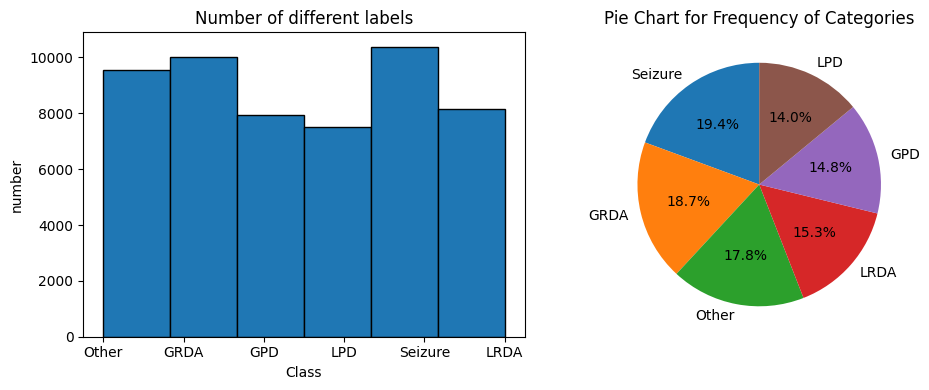

In [6]:
# Get some info
print("The number of training data: {}".format(df.shape[0]))
print("The number of test data:     {} \n".format(len(df_test)))

# Plot the histogram
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['expert_consensus'], bins=len(CFG.class_lst), edgecolor='black')
plt.xlabel('Class')
plt.ylabel('number')
plt.title('Number of different labels')

# Plot the pie plot
plt.subplot(1, 2, 2)
value_counts = df['expert_consensus'].value_counts()
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart for Frequency of Categories')
plt.tight_layout()
plt.show()

### Split the data into training and validation

In [7]:
# Splite the training data into training and validation data
# While tryiing to maintain the expert consensus balanced
# AFTER SPLITE: the folder number is assign to 0 to 9 (10 fold case)
n_splits   = 10
skf        = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=CFG.seed)
df['fold'] = -1

for fold, (_, val_index) in enumerate(skf.split(df.index, df['expert_consensus'])):
    df.loc[df.index[val_index], 'fold'] = fold

val_index   = [1]
test_index  = [2]
train_index = [3,4,5,6,7,8,9]

train_df = df[df['fold'].isin(train_index)]
val_df   = df[df['fold'].isin(val_index)]
test_df  = df[df['fold'].isin(test_index)]

print(" The training data number is {}.\n The validation data number is {}.\n The testing data number is {}.".format(train_df.shape[0],
                                                                                                                    test_df.shape[0],
                                                                                                                    val_df.shape[0]))

 The training data number is 37493.
 The validation data number is 5357.
 The testing data number is 5357.


### Define my dataset

In [12]:
def parquet_to_eeg(eeg_path, offset):
    # In this function i simply modify the data by get rid of nan and set the dtype
    # the reason I use such a easy and simple function is becasuse it simply just load the parquet
    # I left pure and modification in the transform function
    # MORE job need to be done!
    eeg   = pd.read_parquet(eeg_path, columns=CFG.eeg_features)
    start = int(offset * CFG.sample_freq_eeg)
    end   = int(start + CFG.num_sample_eeg)
    egg   = eeg.iloc[start: end].fillna(0).values.astype(CFG.egg_dtype)
    return egg.T

In [13]:
def parquet_to_spec(spec_path, offset):
    # HERE, you can also load specific range of column by adding the second input
    spec  = pd.read_parquet(spec_path).iloc[:, 1:]
    start = int(np.floor(offset * CFG.sample_freq_spec))
    end   = start + CFG.num_sample_spec
    spec  = spec.iloc[start: end].fillna(0).values.astype(CFG.spec_dtype)
    return spec.T

In [14]:
# define my dataset
class MyDataset(Dataset):
    def __init__(self, dataframe, transform_egg=None, transform_spec=None,
                 transform_lab=None, transform_vote=None):
        self.dataframe      = dataframe
        self.transform_egg  = transform_egg
        self.transform_spec = transform_spec
        self.transform_lab  = transform_lab
        self.transform_vote = transform_vote

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        df          = self.dataframe.iloc[idx]
        eeg_path    = df["eeg_path"]
        spec_path   = df["spec_path"]
        eeg_offset  = df["eeg_label_offset_seconds"]
        spec_offset = df["spectrogram_label_offset_seconds"]

        vote        = df[['seizure_vote','lpd_vote','gpd_vote','lrda_vote','grda_vote', 'other_vote']].values.astype("int")
        label       = df['label']

        #eeg         = parquet_to_eeg(eeg_path, eeg_offset)
        spec        = parquet_to_spec(spec_path, spec_offset)
        #if self.transform_egg:
            #egg = self.transform_egg(eeg)[0]
        if self.transform_spec:
            spec = self.transform_spec(spec)[0]
        if self.transform_lab:
            label = self.transform_lab(label)[0]
        if self.transform_vote:
            vote = self.transform_vote(vote)[0]

        return spec, label, vote
        #egg,


In [15]:
# define the dataloader
# YOU could add more transformer, actaully i think that is a good start point to investigate
transform = transforms.Compose([transforms.ToTensor()])

train_dataset       = MyDataset(train_df, transform)
test_dataset        = MyDataset(test_df,   transform)
validation_dataset  = MyDataset(val_df,     transform)

# Define the dataloader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_dataloader   = DataLoader(validation_dataset, batch_size=64, shuffle=False)

In [19]:
def evaluate(model, dataloader, criterion, device):
    model.train()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
      count = 0
      for images, labels, votes in dataloader:
        count += 64
        images, labels, votes = images.to(device), labels.to(device), votes.to(device)
        row_sums = votes.sum(dim=1, keepdim=True)
        normalized_x = votes / row_sums
        images = images.unsqueeze(1)
        outputs = model(images)
        loss = criterion(torch.log_softmax(outputs, dim=1), normalized_x)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_correct += (predicted == labels).sum().item()
        total_val += labels.size(0)
        #print(count)
      val_loss = val_loss / total_val
      val_accuracy = (val_correct / total_val)
      return val_loss, val_accuracy

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
model = models.resnet50()
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = nn.KLDivLoss(reduction='batchmean').to(device)
model = model.to(device)
epochs = 3
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
for i in range(epochs):
  count = 0
  losses = 0
  train_correct = 0
  total_train = 0
  model.train()
  for x, z, k in train_dataloader:
    count += 64
    optimizer.zero_grad()
    x = x.to(device)
    row_sums = k.sum(dim=1, keepdim=True)
    normalized_x = k / row_sums
    x = x.unsqueeze(1)
    output = model(x)
    loss = loss_function(torch.log_softmax(output, dim=1), normalized_x.to(device))
    loss.backward()
    optimizer.step()
    losses += loss.item()
    _, predicted = torch.max(output, 1)
    predicted = predicted.to(device)
    z = z.to(device)
    train_correct += (predicted == z).sum().item()
    total_train += z.size(0)
    if count % 1280 == 0:
      print(count)
  train_loss = losses / total_train
  train_accuracy = (train_correct / total_train) * 100
  print(f"Epoch {i+1} loss: {train_loss}")
  print(f"Epoch {i+1} train_accuracy: {train_accuracy}")
  val_loss, val_accuracy = evaluate(model, val_dataloader, loss_function, device)
  print(f"Epoch {i+1} val_loss: {val_loss} val_accuracy: {val_accuracy}")
model_path = "/content/drive/MyDrive/HMS/resnet50_finetuned.pth"
torch.save(model.state_dict(), model_path)

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
#from your_model_module import YourModelClass
#model = YourModelClass()
model = models.resnet50()
state_dict = torch.load('drive/MyDrive/HMS/resnet50_finetuned.pth')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = nn.KLDivLoss(reduction='batchmean').to(device)
epochs = 3
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
model = model.to(device)
for i in range(epochs):
  count = 0
  losses = 0
  train_correct = 0
  total_train = 0
  for x, z, k in train_dataloader:
    count += 64
    model.train()
    optimizer.zero_grad()
    x = x.to(device)
    row_sums = k.sum(dim=1, keepdim=True)
    normalized_x = k / row_sums
    x = x.unsqueeze(1)
    output = model(x)
    loss = loss_function(torch.log_softmax(output, dim=1), normalized_x.to(device))
    loss.backward()
    optimizer.step()
    losses += loss.item()
    _, predicted = torch.max(output, 1)
    predicted = predicted.to(device)
    z = z.to(device)
    train_correct += (predicted == z).sum().item()
    total_train += z.size(0)
    if count % 1280 == 0:
      print(count)
  train_loss = losses / total_train
  train_accuracy = (train_correct / total_train) * 100
  print(f"Epoch {i+1} loss: {train_loss}")
  print(f"Epoch {i+1} train_accuracy: {train_accuracy}")
  val_loss, val_accuracy = evaluate(model, val_dataloader, loss_function, device)
  print(f"Epoch {i+1} val_loss: {val_loss} val_accuracy: {val_accuracy}")
model_path = "/content/drive/MyDrive/HMS/resnet50_finetuned_last.pth"
torch.save(model.state_dict(), model_path)

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
#from your_model_module import YourModelClass
#model = YourModelClass()
model = models.resnet50()
state_dict = torch.load('/content/drive/MyDrive/HMS/resnet50_finetuned_last.pth')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = nn.KLDivLoss(reduction='batchmean').to(device)
epochs = 2
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
model = model.to(device)
for i in range(epochs):
  count = 0
  losses = 0
  train_correct = 0
  total_train = 0
  for x, z, k in train_dataloader:
    count += 64
    model.train()
    optimizer.zero_grad()
    x = x.to(device)
    row_sums = k.sum(dim=1, keepdim=True)
    normalized_x = k / row_sums
    x = x.unsqueeze(1)
    output = model(x)
    if count == 64:
      print('start')
    if count == 128:
      print('2nd')
    if count == 192:
      print('3rd')
    loss = loss_function(torch.log_softmax(output, dim=1), normalized_x.to(device))
    loss.backward()
    optimizer.step()
    losses += loss.item()
    _, predicted = torch.max(output, 1)
    predicted = predicted.to(device)
    z = z.to(device)
    train_correct += (predicted == z).sum().item()
    total_train += z.size(0)
    if count % 1280 == 0:
      print(count)
  train_loss = losses / total_train
  train_accuracy = (train_correct / total_train) * 100
  print(f"Epoch {i+1} loss: {train_loss}")
  print(f"Epoch {i+1} train_accuracy: {train_accuracy}")
  val_loss, val_accuracy = evaluate(model, val_dataloader, loss_function, device)
  print(f"Epoch {i+1} val_loss: {val_loss} val_accuracy: {val_accuracy}")
model_path = "/content/drive/MyDrive/HMS/resnet50_finetuned_last_6.pth"
torch.save(model.state_dict(), model_path)

start
2nd
3rd
1280
2560
3840
5120
6400
7680
8960
10240
11520
12800
14080
15360
16640
17920
19200
20480
21760
23040
24320
25600
26880
28160
29440
30720
32000
33280
34560
35840
37120
Epoch 1 loss: 0.003548060685695863
Epoch 1 train_accuracy: 84.97052783186196
Epoch 1 val_loss: 0.005959106032385941 val_accuracy: 0.7801008026880717
start
2nd
3rd
1280
2560
3840
5120
6400
7680
8960
10240
11520
12800
14080
15360
16640
17920
19200
20480
21760
23040
24320
25600
26880
28160
29440
30720
32000
33280
34560
35840
37120
Epoch 2 loss: 0.0029950629041130246
Epoch 2 train_accuracy: 86.41346384658469
Epoch 2 val_loss: 0.0058193608370204685 val_accuracy: 0.7795407877543401


In [25]:
from torchvision import models
model = models.resnet50()
state_dict = torch.load("/content/drive/MyDrive/HMS/resnet50_finetuned_last_6.pth")
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.load_state_dict(state_dict)
mode = model.to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = nn.KLDivLoss(reduction='batchmean').to(device)
evaluate(model, test_dataloader, loss_function, device)

(0.006475518911170141, 0.7688202352062722)


MIL(Multiple instance learning)

In [ ]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
class ImageSlicer(nn.Module):
  def __init__(self, vertical_splits=2, horizontal_splits=2):
    super(ImageSlicer, self).__init__()
    self.vertical_splits = vertical_splits
    self.horizontal_splits = horizontal_splits

  def forward(self, x):
    batch_size, channels, height, width = x.shape
    v_step = height // self.vertical_splits
    h_step = width // self.horizontal_splits
    slices = []
    for i in range(self.vertical_splits):
      for j in range(self.horizontal_splits):
        slice = x[:, :, i*v_step:(i+1)*v_step, j*h_step:(j+1)*h_step]
        slices.append(slice)
    return torch.stack(slices, dim=1)
from torchvision.models import resnet50

class MILResNetModel(nn.Module):
  def __init__(self, num_classes):
    super(MILResNetModel, self).__init__()
    self.slicer = ImageSlicer()
    self.feature_extractor = resnet50(pretrained=True)
    self.feature_extractor.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])
    self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.classifier = nn.Linear(2048, num_classes)

  def forward(self, x):
    x = self.slicer(x)
    batch_size, num_slices, channels, slice_height, slice_width = x.shape
    x = x.view(-1, channels, slice_height, slice_width)
    features = self.feature_extractor(x)
    features = self.global_pool(features)
    features = features.view(features.size(0), -1)
    features = features.view(batch_size, num_slices, -1)
    pooled_features = torch.max(features, 1)[0]
    output = self.classifier(pooled_features)
    return output
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MILResNetModel(num_classes=6)
loss_function = nn.KLDivLoss(reduction='batchmean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)
for epoch in range(4):
    model.train()
    losses = 0
    train_correct = 0
    total_train = 0
    count = 0
    for images, labels, votes in train_dataloader:
        count += 64
        images = images.to(device)
        votes = votes.to(device)
        labels = labels.to(device)
        row_sums = votes.sum(dim=1, keepdim=True)
        normalized_x = votes / row_sums
        optimizer.zero_grad()
        images = images.unsqueeze(1)
        output = model(images)
        if count == 64:
          print('start')
        loss = loss_function(torch.log_softmax(output, dim=1), normalized_x)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == labels).sum().item()
        total_train += labels.size(0)
        if count % 1280 == 0:
            print(count)
    train_loss = losses / total_train
    train_accuracy = (train_correct / total_train) * 100
    print(f"Epoch {epoch+1} loss: {train_loss}")
    print(f"Epoch {epoch+1} train_accuracy: {train_accuracy}")
    val_loss, val_accuracy = evaluate(model, val_dataloader, loss_function, device)
    print(f"Epoch {epoch+1} val_loss: {val_loss} val_accuracy: {val_accuracy}")
model_path = "/content/drive/MyDrive/HMS/resnet50_new_finetuned.pth"
torch.save(model.state_dict(), model_path)

In [ ]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
class ImageSlicer(nn.Module):
  def __init__(self, vertical_splits=2, horizontal_splits=2):
    super(ImageSlicer, self).__init__()
    self.vertical_splits = vertical_splits
    self.horizontal_splits = horizontal_splits

  def forward(self, x):
    batch_size, channels, height, width = x.shape
    v_step = height // self.vertical_splits
    h_step = width // self.horizontal_splits
    slices = []
    for i in range(self.vertical_splits):
      for j in range(self.horizontal_splits):
        slice = x[:, :, i*v_step:(i+1)*v_step, j*h_step:(j+1)*h_step]
        slices.append(slice)
    return torch.stack(slices, dim=1)
from torchvision.models import resnet50

class MILResNetModel(nn.Module):
  def __init__(self, num_classes):
    super(MILResNetModel, self).__init__()
    self.slicer = ImageSlicer()
    self.feature_extractor = resnet50()
    self.feature_extractor.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])
    self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.classifier = nn.Linear(2048, num_classes)

  def forward(self, x):
    x = self.slicer(x)
    batch_size, num_slices, channels, slice_height, slice_width = x.shape
    x = x.view(-1, channels, slice_height, slice_width)
    features = self.feature_extractor(x)
    features = self.global_pool(features)
    features = features.view(features.size(0), -1)
    features = features.view(batch_size, num_slices, -1)
    pooled_features = torch.max(features, 1)[0]
    output = self.classifier(pooled_features)
    return output
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MILResNetModel(num_classes=6)
loss_function = nn.KLDivLoss(reduction='batchmean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/HMS/resnet50_new_finetuned.pth'))
for epoch in range(4):
    model.train()
    losses = 0
    train_correct = 0
    total_train = 0
    count = 0
    for images, labels, votes in train_dataloader:
        count += 64
        images = images.to(device)
        votes = votes.to(device)
        labels = labels.to(device)
        row_sums = votes.sum(dim=1, keepdim=True)
        normalized_x = votes / row_sums
        optimizer.zero_grad()
        images = images.unsqueeze(1)
        output = model(images)
        if count == 64:
          print('start')
        loss = loss_function(torch.log_softmax(output, dim=1), normalized_x)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == labels).sum().item()
        total_train += labels.size(0)
        if count % 1280 == 0:
            print(count)
    train_loss = losses / total_train
    train_accuracy = (train_correct / total_train) * 100
    print(f"Epoch {epoch+1} loss: {train_loss}")
    print(f"Epoch {epoch+1} train_accuracy: {train_accuracy}")
    val_loss, val_accuracy = evaluate(model, val_dataloader, loss_function, device)
    print(f"Epoch {epoch+1} val_loss: {val_loss} val_accuracy: {val_accuracy}")
model_path = "/content/drive/MyDrive/HMS/resnet50_new_finetuned_last.pth"
torch.save(model.state_dict(), model_path)

In [15]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
class ImageSlicer(nn.Module):
  def __init__(self, vertical_splits=2, horizontal_splits=2):
    super(ImageSlicer, self).__init__()
    self.vertical_splits = vertical_splits
    self.horizontal_splits = horizontal_splits

  def forward(self, x):
    batch_size, channels, height, width = x.shape
    v_step = height // self.vertical_splits
    h_step = width // self.horizontal_splits
    slices = []
    for i in range(self.vertical_splits):
      for j in range(self.horizontal_splits):
        slice = x[:, :, i*v_step:(i+1)*v_step, j*h_step:(j+1)*h_step]
        slices.append(slice)
    return torch.stack(slices, dim=1)
from torchvision.models import resnet50

class MILResNetModel(nn.Module):
  def __init__(self, num_classes):
    super(MILResNetModel, self).__init__()
    self.slicer = ImageSlicer()
    self.feature_extractor = resnet50()
    self.feature_extractor.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])
    self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.classifier = nn.Linear(2048, num_classes)

  def forward(self, x):
    x = self.slicer(x)
    batch_size, num_slices, channels, slice_height, slice_width = x.shape
    x = x.view(-1, channels, slice_height, slice_width)
    features = self.feature_extractor(x)
    features = self.global_pool(features)
    features = features.view(features.size(0), -1)
    features = features.view(batch_size, num_slices, -1)
    pooled_features = torch.max(features, 1)[0]
    output = self.classifier(pooled_features)
    return output
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MILResNetModel(num_classes=6)
loss_function = nn.KLDivLoss(reduction='batchmean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/HMS/resnet50_new_finetuned_last.pth'))
for epoch in range(4):
    model.train()
    losses = 0
    train_correct = 0
    total_train = 0
    count = 0
    for images, labels, votes in train_dataloader:
        count += 64
        images = images.to(device)
        votes = votes.to(device)
        labels = labels.to(device)
        row_sums = votes.sum(dim=1, keepdim=True)
        normalized_x = votes / row_sums
        optimizer.zero_grad()
        images = images.unsqueeze(1)
        output = model(images)
        if count == 64:
          print('start')
        loss = loss_function(torch.log_softmax(output, dim=1), normalized_x)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == labels).sum().item()
        total_train += labels.size(0)
        if count % 1280 == 0:
          print(count)
    train_loss = losses / total_train
    train_accuracy = (train_correct / total_train) * 100
    print(f"Epoch {epoch+1} loss: {train_loss}")
    print(f"Epoch {epoch+1} train_accuracy: {train_accuracy}")
    val_loss, val_accuracy = evaluate(model, val_dataloader, loss_function, device)
    print(f"Epoch {epoch+1} val_loss: {val_loss} val_accuracy: {val_accuracy}")
model_path = "/content/drive/MyDrive/HMS/resnet50_new_finetuned_last_final.pth"
torch.save(model.state_dict(), model_path)

start
1280
2560
3840
5120
6400
7680
8960
10240
11520
12800
14080
15360
16640
17920
19200
20480
21760
23040
24320
25600
26880
28160
29440
30720
32000
33280
34560
35840
37120
Epoch 1 loss: 0.0039771757671171895
Epoch 1 train_accuracy: 83.55159629797562
Epoch 1 val_loss: 0.006300496013613586 val_accuracy: 0.7672204592122457
start
1280
2560
3840
5120
6400
7680
8960
10240
11520
12800
14080
15360
16640
17920
19200
20480
21760
23040
24320
25600
26880
28160
29440
30720
32000
33280
34560
35840
37120
Epoch 2 loss: 0.0033644588387308494
Epoch 2 train_accuracy: 85.32259355079614
Epoch 2 val_loss: 0.006001203092305723 val_accuracy: 0.7711405637483666
start
1280
2560
3840
5120
6400
7680
8960
10240
11520
12800
14080
15360
16640
17920
19200
20480
21760
23040
24320
25600
26880
28160
29440
30720
32000
33280
34560
35840
37120
Epoch 3 loss: 0.0028672126486642712
Epoch 3 train_accuracy: 86.75486090736938
Epoch 3 val_loss: 0.005315385267920117 val_accuracy: 0.798207952212059
start
1280
2560
3840
5120
6400
7

In [18]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MILResNetModel(num_classes=6)
loss_function = nn.KLDivLoss(reduction='batchmean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/HMS/resnet50_new_finetuned_last_final.pth'))

<All keys matched successfully>

In [21]:
evaluate(model, test_dataloader, loss_function, device)

0.005536576647110477 0.7920739219712526


Different image slices size

In [ ]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
class ImageSlicer(nn.Module):
  def __init__(self, target_height, target_width):
    super(ImageSlicer, self).__init__()
    self.target_height = target_height
    self.target_width = target_width

  def forward(self, x):
    batch_size, channels, height, width = x.shape
    slices = []
    slices.append(x[:, :, 0:self.target_height, 0:self.target_width])
    slices.append(x[:, :, 0:self.target_height, width-self.target_width:width])
    slices.append(x[:, :, height-self.target_height:height, 0:self.target_width])
    slices.append(x[:, :, height-self.target_height:height, width-self.target_width:width])
    return torch.stack(slices, dim=1)
from torchvision.models import resnet50

class MILResNetModel(nn.Module):
  def __init__(self, num_classes):
    super(MILResNetModel, self).__init__()
    self.slicer = ImageSlicer(300, 200)
    self.feature_extractor = resnet50()
    self.feature_extractor.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])
    self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.classifier = nn.Linear(2048, num_classes)

  def forward(self, x):
    x = self.slicer(x)
    batch_size, num_slices, channels, slice_height, slice_width = x.shape
    x = x.view(-1, channels, slice_height, slice_width)
    features = self.feature_extractor(x)
    features = self.global_pool(features)
    features = features.view(features.size(0), -1)
    features = features.view(batch_size, num_slices, -1)
    pooled_features = torch.max(features, 1)[0]
    output = self.classifier(pooled_features)
    return output
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MILResNetModel(num_classes=6)
loss_function = nn.KLDivLoss(reduction='batchmean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)
for epoch in range(6):
    model.train()
    losses = 0
    train_correct = 0
    total_train = 0
    count = 0
    for images, labels, votes in train_dataloader:
        count += 32
        images = images.to(device)
        votes = votes.to(device)
        labels = labels.to(device)
        row_sums = votes.sum(dim=1, keepdim=True)
        normalized_x = votes / row_sums
        optimizer.zero_grad()
        images = images.unsqueeze(1)
        output = model(images)
        if count == 32:
          print('start')
        loss = loss_function(torch.log_softmax(output, dim=1), normalized_x)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == labels).sum().item()
        total_train += labels.size(0)
        if count % 12800 == 0:
            print(count)
    train_loss = losses / total_train
    train_accuracy = (train_correct / total_train) * 100
    print(f"Epoch {epoch+1} loss: {train_loss}")
    print(f"Epoch {epoch+1} train_accuracy: {train_accuracy}")
    val_loss, val_accuracy = evaluate(model, val_dataloader, loss_function, device)
    print(f"Epoch {epoch+1} val_loss: {val_loss} val_accuracy: {val_accuracy}")
model_path = "/content/drive/MyDrive/HMS/resnet50_new_finetuned_last_200300.pth"
torch.save(model.state_dict(), model_path)

start
12800
25600
38400
51200
64000
Epoch 1 loss: 0.03702332276179231
Epoch 1 train_accuracy: 37.077314071696094
Epoch 1 val_loss: 0.03281196806761209 val_accuracy: 0.45720973782771535
start
12800
25600
38400
51200
64000
Epoch 2 loss: 0.026285259063675036
Epoch 2 train_accuracy: 57.33681112894596
Epoch 2 val_loss: 0.026960510794031486 val_accuracy: 0.5441011235955057
start
12800
25600
38400
51200
64000
Epoch 3 loss: 0.021735154585429472
Epoch 3 train_accuracy: 63.97137506688069
Epoch 3 val_loss: 0.023977045851588694 val_accuracy: 0.6
start
12800
25600
38400
51200
64000
Epoch 4 loss: 0.01864221552242373
Epoch 4 train_accuracy: 68.51257356875334
Epoch 4 val_loss: 0.021170320819491304 val_accuracy: 0.6358614232209738
start
12800
25600
38400
